# MIA on DP-Trained models

In this notebook we will explore the tensorflow privacy framework, especially the DP enchanced optimizers. We will train our default CNN model on a slice of CIFAR-10 data using a DP enchanced optimizer (either adam or sgd) and then use the default attack on the target model to check the results. 

Attacker knowledge:
- Dataset Distribution
- Model Type, NOT the exact structure or tuning of the model
- Prediction Confidence for each class on a datapoint (confidence vector)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, datasets
from sklearn.model_selection import train_test_split

tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()
tf.get_logger().setLevel('ERROR')
!pip install tensorflow-privacy
import tensorflow_privacy
import numpy as np
import matplotlib.pyplot as plt

import math
import tensorflow as tf


from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer

# for image interpolation
import scipy.ndimage.interpolation as interpolation

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report


from mia.attack_model import *
from mia.label_only import *
from mia.shadow_models import *
from mia.utilities import *
from mia.wrappers import *


from tqdm.notebook import tqdm
import sys

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Instructions for updating:
non-resource variables are not supported in the long term
Num GPUs Available:  1


## Target Model


In [2]:
from keras.callbacks import EarlyStopping, LearningRateScheduler

D_TARGET_SIZE = 10000

learning_rate = 0.001
noise_multiplier = 1.1
l2_norm_clip = 2.5
batch_size = 100
num_microbatches = 100
epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1e-4, patience=20)

def step_decay(epoch):
  initial_lrate = 0.001
  drop = 1e-5
  epochs_drop = 100
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate, es]


In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
#shuffle the datasets
sample_i = np.random.choice(range(train_images.shape[0]), train_images.shape[0], replace=False)
train_images = train_images[sample_i]
train_labels = train_labels[sample_i]
sample_i = np.random.choice(range(test_images.shape[0]), test_images.shape[0], replace=False)
test_images = test_images[sample_i]
test_labels = test_labels[sample_i] 

# use the rest as testing - 'out' records
attacker_labels = np.concatenate((train_labels[D_TARGET_SIZE:], test_labels))
attacker_images = np.concatenate((train_images[D_TARGET_SIZE:], test_images))
target_images = train_images[:D_TARGET_SIZE]
target_labels = train_labels[:D_TARGET_SIZE]

target_images = np.array(target_images, dtype=np.float32)
attacker_images = np.array(attacker_images, dtype=np.float32)


In [4]:
def f_target_def():
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='tanh'),
  layers.MaxPooling2D((2, 2)),

  layers.Flatten(),
  layers.Dense(128, activation='tanh'),
  layers.Dense(10)
  ])
  model.summary()

  optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)
  
  loss = loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

  model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
  return model

In [5]:
def f_target():
  """
  Returns a trained target model, if test data are specified we will evaluate the model and print its accuracy
  """
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32,32,3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(512, activation='relu'))

  model.add(layers.Dense(10))
  model.summary()

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  
  loss = loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
  return model

In [6]:
train_images, eval_images, train_labels, eval_labels = train_test_split(target_images, target_labels, test_size=0.2, shuffle=True)
target_model = f_target() 
target_model_def = f_target_def()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                    

In [7]:
history = target_model.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(eval_images, eval_labels), callbacks=[es, lrate])

Epoch 1/200
80/80 [==============================] - 4s 24ms/step - loss: 2.1141 - accuracy: 0.2355 - val_loss: 1.8251 - val_accuracy: 0.3310 - lr: 0.0010
Epoch 2/200
80/80 [==============================] - 2s 20ms/step - loss: 1.6586 - accuracy: 0.3904 - val_loss: 1.6849 - val_accuracy: 0.3735 - lr: 0.0010
Epoch 3/200
80/80 [==============================] - 2s 21ms/step - loss: 1.4868 - accuracy: 0.4516 - val_loss: 1.6728 - val_accuracy: 0.4320 - lr: 0.0010
Epoch 4/200
80/80 [==============================] - 2s 23ms/step - loss: 1.3536 - accuracy: 0.5065 - val_loss: 1.5039 - val_accuracy: 0.4710 - lr: 0.0010
Epoch 5/200
80/80 [==============================] - 2s 23ms/step - loss: 1.2149 - accuracy: 0.5612 - val_loss: 1.4977 - val_accuracy: 0.4915 - lr: 0.0010
Epoch 6/200
80/80 [==============================] - 2s 24ms/step - loss: 1.1033 - accuracy: 0.6051 - val_loss: 1.5043 - val_accuracy: 0.4840 - lr: 0.0010
Epoch 7/200
80/80 [==============================] - 2s 24ms/step - lo

In [8]:
history = target_model_def.fit(train_images, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(eval_images, eval_labels), callbacks=[es, lrate])

Epoch 1/200
80/80 [==============================] - 43s 502ms/step - loss: 2.3022 - accuracy: 0.1538 - val_loss: 2.1908 - val_accuracy: 0.1945 - lr: 0.0010
Epoch 2/200
80/80 [==============================] - 40s 502ms/step - loss: 2.1283 - accuracy: 0.2138 - val_loss: 2.0808 - val_accuracy: 0.2270 - lr: 0.0010
Epoch 3/200
80/80 [==============================] - 40s 504ms/step - loss: 2.0451 - accuracy: 0.2449 - val_loss: 2.0318 - val_accuracy: 0.2445 - lr: 0.0010
Epoch 4/200
80/80 [==============================] - 40s 496ms/step - loss: 1.9876 - accuracy: 0.2639 - val_loss: 1.9881 - val_accuracy: 0.2615 - lr: 0.0010
Epoch 5/200
80/80 [==============================] - 40s 497ms/step - loss: 1.9437 - accuracy: 0.2903 - val_loss: 1.9406 - val_accuracy: 0.2770 - lr: 0.0010
Epoch 6/200
80/80 [==============================] - 40s 496ms/step - loss: 1.9165 - accuracy: 0.2957 - val_loss: 1.9057 - val_accuracy: 0.2985 - lr: 0.0010
Epoch 7/200
80/80 [==============================] - 40s 4

In [9]:
N_SHADOWS = 2
D_SHADOW_SIZE = 10000

In [10]:
def f_attack():

  model = models.Sequential(name='conf-vector-attack_model')
  model.add(layers.Dense(10, input_shape=(11, )))
  model.add(layers.LeakyReLU(0.3))
  model.add(layers.Dense(1, activation='sigmoid'))
        
  model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
  
  print(model.summary())
  return model 

In [11]:
attack = ConfidenceVectorAttack(target_model, 
                                (train_images, train_labels), 
                                (attacker_images, attacker_labels), 
                                attack_model_creator=f_attack, 
                                shadow_creator=f_target, 
                                n_shadows=N_SHADOWS, 
                                D_shadow_size=D_SHADOW_SIZE, 
                                verbose=True)

In [12]:
attack.perform_attack(shadow={'epochs':25, 'batch_size':128}, attack={'epochs':50, 'batch_size':128})

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

class-1 acc: 0.5918238759040833
class-2 acc: 0.6036922931671143
class-3 acc: 0.585995078086853
class-4 acc: 0.5930305123329163
class-5 acc: 0.5741565823554993
class-6 acc: 0.6369550824165344
class-7 acc: 0.5998743772506714
class-8 acc: 0.628134548664093
class-9 acc: 0.5794681310653687
class-10 acc: 0.610763430595398
              precision    recall  f1-score   support

         Out       0.60      0.61      0.60      8000
          In       0.60      0.59      0.60      8000

    accuracy                           0.60     16000
   macro avg       0.60      0.60      0.60     16000
weighted avg       0.60      0.60      0.60     16000

AUC: 0.630649140625


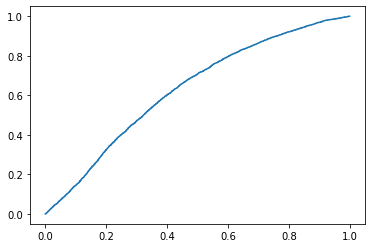

In [13]:
res = attack.evaluate_attack()

class-1 acc: 0.49685534834861755
class-2 acc: 0.508307695388794
class-3 acc: 0.4944717586040497
class-4 acc: 0.4984443187713623
class-5 acc: 0.48758751153945923
class-6 acc: 0.5003253221511841
class-7 acc: 0.5050251483917236
class-8 acc: 0.48685014247894287
class-9 acc: 0.5102040767669678
class-10 acc: 0.49436795711517334
              precision    recall  f1-score   support

         Out       0.50      0.80      0.61      8000
          In       0.50      0.20      0.28      8000

    accuracy                           0.50     16000
   macro avg       0.50      0.50      0.45     16000
weighted avg       0.50      0.50      0.45     16000

AUC: 0.49902071875


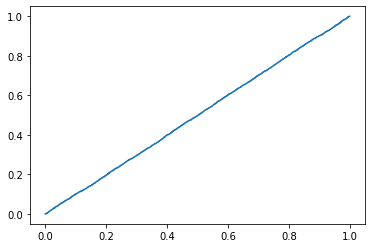

In [14]:
attack.target_model = target_model_def
res = attack.evaluate_attack()